In [1]:
from rdkit import Chem
from sklearn.metrics import roc_auc_score
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    GCNConv,
    global_mean_pool,
    global_add_pool
)
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F

In [ ]:
import random
import numpy as np

# Ensure reproducibility with a fixed seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # For deterministic behavior in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a global seed for reproducibility
SEED = 42
set_seed(SEED)

In [2]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Preprocessing SMILES Data into Graphs

In [13]:
import numpy as np
from rdkit.Chem import rdFingerprintGenerator
import deepchem as dc

# Featurization using DeepChem's MolGraphConvFeaturizer
def featurize_smiles(smiles):
    featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
    graph_data = featurizer.featurize([smiles])[0]
    
    # Get DeepChem atom features
    atom_features_deepchem = graph_data.node_features
    
    return atom_features_deepchem

# Function to generate Morgan Fingerprints (ECFP)
def generate_ecfp(smiles):
    # Morgan fingerprint generator
    mfgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096)

    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        return None
    return mfgen.GetFingerprintAsNumPy(molecule)

# Function to convert SMILES to PyTorch Geometric Data object using DeepChem featurizer
def smiles_to_graph_featurizer(smiles):
    # Featurization using DeepChem
    featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)

    # Featurize the SMILES string using DeepChem
    graph_data = featurizer.featurize([smiles])[0]
    return graph_data.node_features, graph_data.edge_features, graph_data.edge_index

# Function to extract atom features
def atom_features(atom, ecfp):
    # Get the atom index for corresponding ECFP value
    atom_idx = atom.GetIdx()
    
    return  [
            atom.GetAtomicNum(),  # Atomic number
            atom.GetDegree(),  # Number of bonds
            atom.GetTotalNumHs(),  # Total number of hydrogens
            atom.GetFormalCharge(),  # Formal charge of the atom
            atom.GetImplicitValence(),  # Implicit valence
            atom.GetNumRadicalElectrons(),  # Number of radical electrons
            int(atom.GetIsAromatic()),  # Is the atom aromatic?
            atom.GetMass(),  # Atomic mass
            atom.GetHybridization().real,  # Hybridization state (SP, SP2, SP3, etc.)
            ecfp[atom_idx],  # Morgan fingerprint (ECFP) for the atom
        ]


# Function to extract bond features
def bond_features(bond):
    bond_type = bond.GetBondTypeAsDouble()            # Bond type as a float
    is_aromatic = bond.GetIsAromatic()                # Aromatic bond
    is_conjugated = bond.GetIsConjugated()            # Conjugated bond
    is_in_ring = bond.IsInRing()                      # Whether the bond is part of a ring
    stereo = bond.GetStereo()                         # Bond stereochemistry
    
    # Convert stereo information to a one-hot encoded format
    stereo_one_hot = [0, 0, 0, 0]  # Stereo options: None, E, Z, Other
    if stereo == Chem.BondStereo.STEREONONE:
        stereo_one_hot[0] = 1
    elif stereo == Chem.BondStereo.STEREOE:
        stereo_one_hot[1] = 1
    elif stereo == Chem.BondStereo.STEREOZ:
        stereo_one_hot[2] = 1
    else:
        stereo_one_hot[3] = 1
    
    # Combine all features into a single tensor
    return torch.tensor(
        [bond_type, float(is_aromatic), float(is_conjugated), float(is_in_ring)] + stereo_one_hot, dtype=torch.float
    )


# Convert SMILES to PyTorch Geometric Data object
def smiles_to_graph(smiles, label):
    mol = Chem.MolFromSmiles(smiles)

    atom_features_list = []
    edge_index = []
    edge_attr = []

    # DeepChem features
    atom_features_deepchem = featurize_smiles(smiles)

    # Generate Morgan Fingerprint (ECFP)
    ecfp_features = generate_ecfp(smiles)

    # Generate Molecule Graph Convolution features
    mol_graph_node_features, mol_graph_edge_features, mol_graph_edge_index = smiles_to_graph_featurizer(smiles)

    # Nodes (atoms)
    for atom in mol.GetAtoms():
        atom_features_list.append(atom_features(atom, ecfp_features))

    atom_features_list = np.array(atom_features_list)

    # Edges (bonds)
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        
        # Append bidirectional edges for undirected graphs
        edge_index.append([i, j])
        edge_index.append([j, i])
        
        # Append bond features for both directions
        edge_attr.append(bond_features(bond))
        edge_attr.append(bond_features(bond))

    # Convert atom features to a tensor
    combined_features = np.concatenate((atom_features_list, atom_features_deepchem, mol_graph_node_features), axis=1)
    x = torch.tensor(combined_features, dtype=torch.float)

    # Convert edge indices and features to tensors, handle empty edge case
    if edge_index:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.stack(edge_attr)
    else:
        # Handle molecules with no bonds
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0,), dtype=torch.float)

    # Label (target)
    y = torch.tensor([label], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)



# Function to load data from CSV and apply SMILES augmentation for training
def load_data_from_csv(file_path):
    df = pd.read_csv(file_path)
    smiles_list = df["Smiles"].values
    labels = df["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0).values

    data_list = []

    # Initialize the SmilesEnumerator for data augmentation
    for smiles, label in zip(smiles_list, labels):
        # For test data, no augmentation, just use canonical SMILES
        graph_data = smiles_to_graph(smiles, label)
        data_list.append(graph_data)

    return data_list

In [18]:
# Load training and testing data
training_data = load_data_from_csv("data_smiles/Training_Group.csv")
testing_data = load_data_from_csv("data_smiles/Testing_Group.csv")

# Create data loaders
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=32, shuffle=False)

In [17]:
# for i, data in enumerate(test_loader):
#     print(data)

#     if i == 2:
#         break

DataBatch(x=[40, 70], edge_index=[2, 88], edge_attr=[88, 8], y=[1], batch=[40], ptr=[2])
DataBatch(x=[15, 70], edge_index=[2, 30], edge_attr=[30, 8], y=[1], batch=[15], ptr=[2])
DataBatch(x=[27, 70], edge_index=[2, 58], edge_attr=[58, 8], y=[1], batch=[27], ptr=[2])


In [19]:
# Training function with AUC and accuracy tracking
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    y_true = []
    y_pred = []

    for data in data_loader:
        data = data.to(device)  # Move data to GPU
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        # Track metrics
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        y_true.extend(data.y.cpu().tolist())  # Move back to CPU for metrics
        y_pred.extend(out[:, 1].detach().cpu().numpy())  # Probability for class 1

    acc = correct / len(data_loader.dataset)
    auc = roc_auc_score(y_true, y_pred)

    return total_loss / len(data_loader), acc, auc

In [20]:
# Evaluation function with AUC and accuracy tracking
def test(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)  # Move data to GPU
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            y_true.extend(data.y.cpu().tolist())  # Move back to CPU for metrics
            y_pred.extend(out[:, 1].cpu().numpy())  # Probability for class 1

    acc = correct / len(data_loader.dataset)
    auc = roc_auc_score(y_true, y_pred)

    return total_loss / len(data_loader), acc, auc

# GCN approach

## 2. Define GCN Model

In [31]:
SEED = 42
set_seed(SEED)

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_dim=64, dropout_prob=0.5):
        super(GCN, self).__init__()
        self.init_conv = GCNConv(num_node_features, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.dropout_prob = dropout_prob
        self.fc = torch.nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.init_conv(x, edge_index)
        x = F.tanh(x)
        x = self.conv1(x, edge_index)
        x = F.tanh(x)
        x = self.conv2(x, edge_index)
        x = F.tanh(x)
        x = self.conv3(x, edge_index)
        x = F.tanh(x)
        x = torch.cat([global_mean_pool(x, batch), global_add_pool(x, batch)], dim=1)
        x = F.dropout(x, p=self.dropout_prob, training=self.training)  # Apply dropout
        return F.log_softmax(self.fc(x), dim=1)

## 3. Training Loop with Early Stopping and Metric Tracking

In [34]:
# Best trial: {'hidden_dim': 63, 'dropout_prob': 0.1321079856842423, 'lr': 8.479899789764961e-05, 'weight_decay': 6.868751761280333e-06}
best_params = {'hidden_dim': 87, 'dropout_prob': 0.5503994913345506, 'lr': 0.0009990953045534545, 'weight_decay': 6.999570778482214e-05}

# Initialize the model with the best hyperparameters
best_model = GCN(
    num_node_features=70,  # Adjust if needed
    num_classes=2,
    hidden_dim=best_params['hidden_dim'],
    dropout_prob=best_params['dropout_prob']
).to(device)

# Initialize optimizer with the best hyperparameters
best_optimizer = torch.optim.Adam(
    best_model.parameters(), 
    lr=best_params['lr'], 
    weight_decay=best_params['weight_decay']
)

In [35]:
# # Initialize the model, optimizer, and loss function
# model = GCN(num_node_features=40, num_classes=2, hidden_dim=63, dropout_prob=0.5).to(device)
# optimizer = torch.optim.Adam(
#     model.parameters(), lr=8.479899789764961e-05, weight_decay=6.868751761280333e-06
# )  # Increase weight decay value
model = best_model
optimizer = best_optimizer
criterion = torch.nn.CrossEntropyLoss()

best_auc = 0
early_stop_counter = 0
max_epochs = 1000  # Max epochs
patience = 100  # Early stopping patience

# Metrics storage for plotting
train_acc_history, train_loss_history, train_auc_history = [], [], []
test_acc_history, test_loss_history, test_auc_history = [], [], []

SEED = 42
set_seed(SEED)

for epoch in range(max_epochs):
    train_loss, train_acc, train_auc = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc, test_auc = test(model, test_loader, criterion)

    # Store metrics for plotting
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
    train_auc_history.append(train_auc)
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss)
    test_auc_history.append(test_auc)

    print(f"Epoch {epoch+1}:")
    print(
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}"
    )
    print(
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}"
    )

    # Early stopping
    if test_auc > best_auc:
        best_auc = test_auc
        early_stop_counter = 0  # Reset counter if improvement
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1:
Train Loss: 2.5535, Train Acc: 0.5052, Train AUC: 0.5091
Test Loss: 0.7924, Test Acc: 0.4161, Test AUC: 0.6568
Epoch 2:
Train Loss: 1.3010, Train Acc: 0.5117, Train AUC: 0.5137
Test Loss: 0.5891, Test Acc: 0.7692, Test AUC: 0.6232
Epoch 3:
Train Loss: 1.0240, Train Acc: 0.5391, Train AUC: 0.5354
Test Loss: 0.5373, Test Acc: 0.7657, Test AUC: 0.6847
Epoch 4:
Train Loss: 0.8711, Train Acc: 0.5431, Train AUC: 0.5390
Test Loss: 0.5425, Test Acc: 0.7657, Test AUC: 0.7314
Epoch 5:
Train Loss: 0.7908, Train Acc: 0.5600, Train AUC: 0.5606
Test Loss: 0.5582, Test Acc: 0.7797, Test AUC: 0.7231
Epoch 6:
Train Loss: 0.7244, Train Acc: 0.5641, Train AUC: 0.5876
Test Loss: 0.5841, Test Acc: 0.7203, Test AUC: 0.7529
Epoch 7:
Train Loss: 0.7072, Train Acc: 0.5624, Train AUC: 0.5796
Test Loss: 0.5481, Test Acc: 0.7727, Test AUC: 0.7014
Epoch 8:
Train Loss: 0.6954, Train Acc: 0.5786, Train AUC: 0.5988
Test Loss: 0.6027, Test Acc: 0.7308, Test AUC: 0.7463
Epoch 9:
Train Loss: 0.6949, Train Acc: 

In [37]:
# Evaluate the model on the test set
test_loss, test_acc, test_auc = test(best_model, test_loader, criterion)

# Print the evaluation metrics
print(f"Evaluation Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Evaluation Results:
Test Loss: 0.5430
Test Accuracy: 0.7273
Test AUC: 0.7548


## 4. Evaluation function

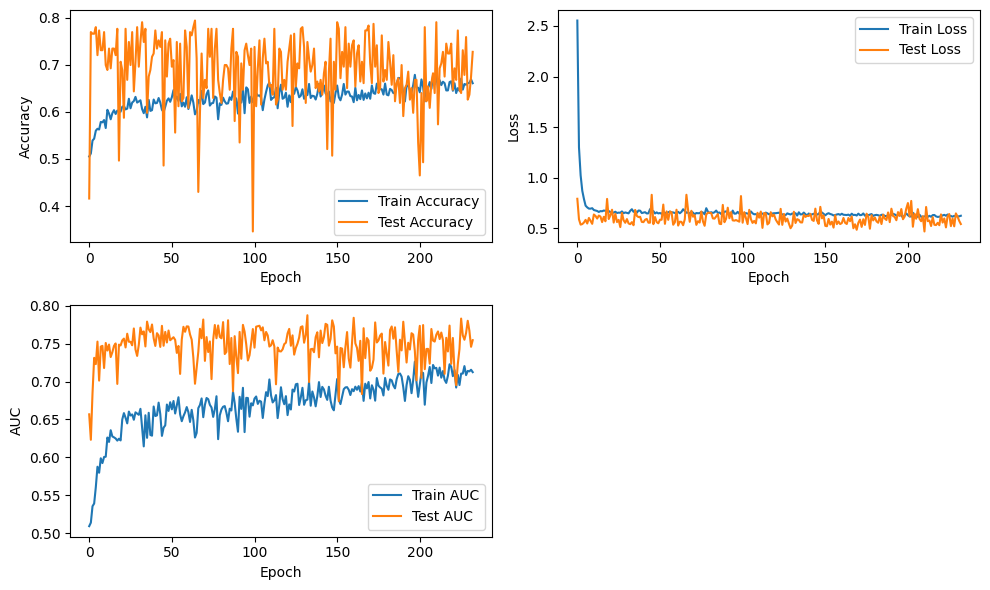

In [38]:
# Plot training and testing accuracy
epochs = len(train_acc_history)
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(range(epochs), train_acc_history, label="Train Accuracy")
plt.plot(range(epochs), test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(epochs), train_loss_history, label="Train Loss")
plt.plot(range(epochs), test_loss_history, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot AUC for train and test
plt.subplot(2, 2, 3)
plt.plot(range(epochs), train_auc_history, label="Train AUC")
plt.plot(range(epochs), test_auc_history, label="Test AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()

# Optuna

In [21]:
import optuna
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_add_pool

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_dim=64, dropout_prob=0.5):
        super(GCN, self).__init__()
        self.init_conv = GCNConv(num_node_features, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.dropout_prob = dropout_prob
        self.fc = torch.nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.init_conv(x, edge_index)
        x = F.tanh(x)
        x = self.conv1(x, edge_index)
        x = F.tanh(x)
        x = self.conv2(x, edge_index)
        x = F.tanh(x)
        x = self.conv3(x, edge_index)
        x = F.tanh(x)
        x = torch.cat([global_mean_pool(x, batch), global_add_pool(x, batch)], dim=1)
        x = F.dropout(x, p=self.dropout_prob, training=self.training)  # Apply dropout
        return F.log_softmax(self.fc(x), dim=1)

In [25]:
# Define the objective function for Optuna optimization
def objective(trial):
    # Set the seed for reproducibility in this trial
    set_seed(SEED)
    
    # Suggest hyperparameters
    hidden_dim = trial.suggest_int('hidden_dim', 32, 256)
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.6)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)

    # Initialize the model
    model = GCN(num_node_features=70, num_classes=2, hidden_dim=hidden_dim, dropout_prob=dropout_prob).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    best_auc = 0
    early_stop_counter = 0
    patience = 10  # Early stopping patience

    # Training loop
    for epoch in range(100):
        train_loss, train_acc, train_auc = train(model, train_loader, optimizer, criterion)
        test_loss, test_acc, test_auc = test(model, test_loader, criterion)

        # Early stopping
        if test_auc > best_auc:
            best_auc = test_auc
            early_stop_counter = 0  # Reset counter if improvement
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            break

    # Return the best AUC score for this trial
    return best_auc

In [26]:
# Run the Optuna study with the fixed seed
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=50)

[I 2024-10-19 11:26:59,484] A new study created in memory with name: no-name-95a5e3d6-c514-4f59-9902-faaf372c6d47
[I 2024-10-19 11:27:07,503] Trial 0 finished with value: 0.7732683605986773 and parameters: {'hidden_dim': 116, 'dropout_prob': 0.5753571532049581, 'lr': 0.001570297088405539, 'weight_decay': 0.0002481040974867811}. Best is trial 0 with value: 0.7732683605986773.
[I 2024-10-19 11:27:25,080] Trial 1 finished with value: 0.7071353985381135 and parameters: {'hidden_dim': 67, 'dropout_prob': 0.17799726016810133, 'lr': 1.493656855461762e-05, 'weight_decay': 0.0029154431891537554}. Best is trial 0 with value: 0.7732683605986773.
[I 2024-10-19 11:27:49,208] Trial 2 finished with value: 0.7199443090845805 and parameters: {'hidden_dim': 167, 'dropout_prob': 0.4540362888980227, 'lr': 1.1527987128232396e-05, 'weight_decay': 0.007579479953348004}. Best is trial 0 with value: 0.7732683605986773.
[I 2024-10-19 11:27:59,206] Trial 3 finished with value: 0.7457709711103377 and parameters: 

In [28]:
print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value: 0.7876087713191786
  Params: 
    hidden_dim: 87
    dropout_prob: 0.5503994913345506
    lr: 0.0009990953045534545
    weight_decay: 6.999570778482214e-05


In [29]:
print(f"Best trial: {study.best_trial.params}")


Best trial: {'hidden_dim': 87, 'dropout_prob': 0.5503994913345506, 'lr': 0.0009990953045534545, 'weight_decay': 6.999570778482214e-05}
